In [14]:
import numpy as np
import matplotlib.pyplot as plt

We have already done the FTT for 1D and 2D, and checked the analytical solution for a perfect gaussian wave in vacuum. Now, we try to add effects of the atmosphere:

$$\frac{\partial \varepsilon}{\partial z}=-\frac{i}{2k_0}  \Delta_T\varepsilon - \frac{i k_0\delta n(z, y, x)}{2}\varepsilon,  \qquad(Eq. 1)
$$

We begin with the normal spectral class, and will change the advance step with the split step technique. I will work with 1D first again, see the results, then go to 2D

In [2]:
#trying changing the spatial domain

class Spectral:
    def __init__(self, L, number_of_points, k_0):
        self.L = L
        self.number_of_points = number_of_points
        self.k_0 = k_0
        
        
        self.x_grid = np.linspace(-10*L, 10*L, number_of_points, endpoint=False)
        self.k_grid = 2 * np.pi * np.fft.fftfreq(number_of_points, d=20*L/number_of_points)
        
        
        self.D = -1j / (2 * k_0)
        self.epsilon = None
        
    def initialize(self, function):
        if len(function) != self.number_of_points:
            raise ValueError("Function length doesn't match grid size.")
        self.epsilon = function
        
    def step(self, dz):
        if self.epsilon is None:
            raise ValueError("Initialize epsilon before stepping.")
        
        epsilon_hat = np.fft.fft(self.epsilon)
        
        epsilon_hat *= np.exp(-self.D * self.k_grid**2 * dz)
                
        self.epsilon = np.fft.ifft(epsilon_hat)
        
        return self.epsilon

In [30]:
def advance_part(spectral, Z, N, n = None):
    dz = Z / N
    epsilon_evolution = []
    if n is not None:
        for i in range(N):
            chi = 1j * (n[i]**2-1)*spectral.k_0/2
            a = spectral.step(dz)
            a[:2**10] = a[:2**10]*np.exp(-chi*dz)
            epsilon_evolution.append(a)
            spectral.initialize(a)
    else:
        for _ in range(N):
            epsilon_evolution.append(spectral.step(dz))
    return np.array(epsilon_evolution)

In [31]:
def advance(spectral, Z, N, n = None):
    dz = Z / N
    epsilon_evolution = []
    if n is not None:
        for i in range(N):
            chi = 1j * (n[i]**2-1)*spectral.k_0/2
            a = spectral.step(dz)
            b = a*np.exp(-chi*dz)
            epsilon_evolution.append(b)
            spectral.initialize(b)
    else:
        for _ in range(N):
            epsilon_evolution.append(spectral.step(dz))
    return np.array(epsilon_evolution)

In [4]:
def analytical_solution(Z, D, amplitude, sigma, x_val): #without the atmosphere
    return (amplitude/np.sqrt(1+(4*D*Z/sigma**2))*np.exp(-x_val**2/(sigma**2+4*D*Z)))

$$z_R = \frac{\pi \omega_0^2 n}{\lambda}$$
Here $z_R$ refers to the rayleigh range, the length at which the beam will have $\sqrt{2}$ times its initial width. 

Also, we have the following equation:$$\omega(z) = \omega_0\sqrt{1+\left(\frac{z}{z_R}\right)^2}$$
This gives us the value of $z$ for which the beam doubles in width: $$z = \sqrt{3}z_R$$

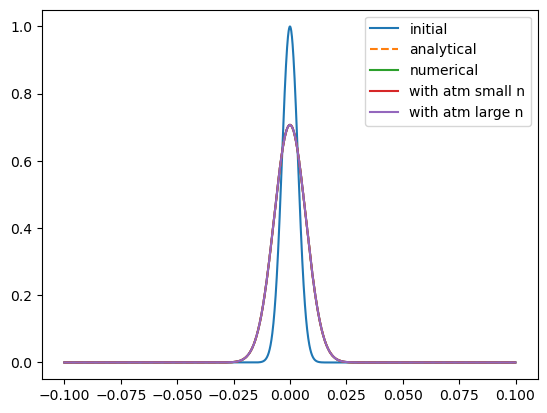

In [34]:
L = 0.01 #Which is the width of the opening of the beam
number_of_points = 2**11 #the number of points for the grid over which we calculate everything
k_0 = 2*np.pi/635 *10**9 #red light
N = 10**4 #numerically calculate over these many points 
n1 = 1+ np.linspace(10**-2,0, N)
n2 = 1+np.linspace(1, 0, N)
z_R = (L/2)**2*k_0/2
Z = z_R * np.sqrt(3)
# Z = 214m

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N)
spectral.initialize(epsilon_initial)
ep_evo_with_atm_small_n = advance(spectral, Z, N, n1)
spectral.initialize(epsilon_initial)
ep_evo_with_atm_large_n = advance(spectral, Z, N, n2)



plt.plot(spectral.x_grid, epsilon_evolution[0], label='initial')
plt.plot(spectral.x_grid, np.abs(analytical_solution(Z, spectral.D, 1, L/2, spectral.x_grid)),'--', label='analytical')
plt.plot(spectral.x_grid, np.abs(epsilon_evolution[-1]), label='numerical')
plt.plot(spectral.x_grid, np.abs(ep_evo_with_atm_small_n[-1]), label='with atm small n')
plt.plot(spectral.x_grid, np.abs(ep_evo_with_atm_large_n[-1]), label='with atm large n')

plt.legend()

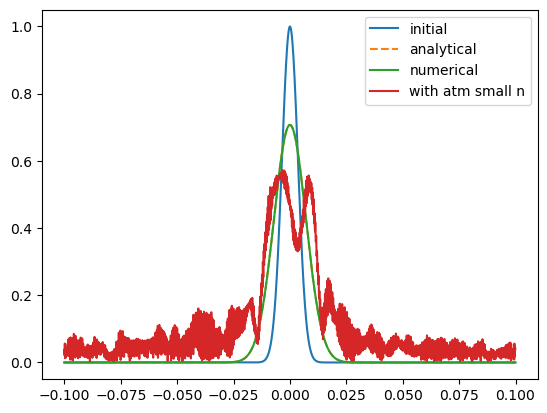

In [36]:
L = 0.01 #Which is the width of the opening of the beam
number_of_points = 2**11 #the number of points for the grid over which we calculate everything
k_0 = 2*np.pi/635 *10**9 #red light
N = 10**4 #numerically calculate over these many points 
n1 = 1+ np.linspace(10**-4,0, 100)
z_R = (L/2)**2*k_0/2
Z = z_R * np.sqrt(3)
# Z = 214m

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N)
spectral.initialize(epsilon_initial)
ep_evo_with_atm_small_n_p = advance(spectral, 100, 1000)
ep_evo_with_atm_small_n_p= advance_part(spectral, 15, 100, n1)
ep_evo_with_atm_small_n_p=(advance(spectral, Z-100-15, 1000))

plt.plot(spectral.x_grid, epsilon_evolution[0], label='initial')
plt.plot(spectral.x_grid, np.abs(analytical_solution(Z, spectral.D, 1, L/2, spectral.x_grid)),'--', label='analytical')
plt.plot(spectral.x_grid, np.abs(epsilon_evolution[-1]), label='numerical')
plt.plot(spectral.x_grid, np.abs(ep_evo_with_atm_small_n_p[-1]), label='with atm small n')

plt.legend()

Now we try to do the same thing with 2D

In [6]:
class Spectral2D:
    def __init__(self, Lx, Ly, number_of_points_x, number_of_points_y, k_0):
        self.Lx = Lx
        self.Ly = Ly
        self.number_of_points_x = number_of_points_x
        self.number_of_points_y = number_of_points_y
        self.k_0 = k_0
        

        self.x_grid = np.linspace(-10*Lx, 10*Lx, number_of_points_x, endpoint=False)
        self.y_grid = np.linspace(-10*Ly, 10*Ly, number_of_points_y, endpoint=False)
        self.kx_grid = 2 * np.pi * np.fft.fftfreq(number_of_points_x, d=20*Lx/number_of_points_x)
        self.ky_grid = 2 * np.pi * np.fft.fftfreq(number_of_points_y, d=20*Ly/number_of_points_y)
        

        self.X, self.Y = np.meshgrid(self.x_grid, self.y_grid)
        self.Kx, self.Ky = np.meshgrid(self.kx_grid, self.ky_grid)
        
       
        self.D = 1j / (2 * k_0)
        self.epsilon = None
        
    def initialize(self, function):
        self.epsilon = function
        
    def step(self, dz):
        if self.epsilon is None:
            raise ValueError("Initialize epsilon before stepping.")
        
        epsilon_hat = np.fft.fft2(self.epsilon)
        
        epsilon_hat *= np.exp(-self.D * (self.Kx**2 + self.Ky**2) * dz)
        
        self.epsilon = np.fft.ifft2(epsilon_hat)
        
        return self.epsilon


In [7]:
def advance2D(spectral, Z, N, n=None):
    dz = Z / N
    epsilon_evolution = []
    if n is None:
        for _ in range(N):
            epsilon_evolution = (spectral.step(dz))
    else:
        for i in range(N):
            chi = 1j * (n[i]**2-1)*spectral.k_0/2
            a = spectral.step(dz)
            b = a*np.exp(-chi*dz)
            epsilon_evolution = (b)
            spectral.initialize(b)
    return (epsilon_evolution)

In [41]:
def advance2D_part(spectral, Z, N, n=None):
    dz = Z / N
    epsilon_evolution = []
    if n is None:
        for _ in range(N):
            epsilon_evolution = (spectral.step(dz))
    else:
        for i in range(N):
            chi = 1j * (n[i]**2-1)*spectral.k_0/2
            a = spectral.step(dz)
            a[:2**7] = a[:2**7]*np.exp(-chi*dz)
            epsilon_evolution = a
            spectral.initialize(a)
    return (epsilon_evolution)

In [8]:
def exponential2D(spectral):
    return np.exp(-spectral.X**2/(spectral.Lx/2)**2 - spectral.Y**2/(spectral.Lx/2)**2)

In [42]:
Lx = 0.1
Ly = 0.1
number_of_points_x = 2**9
number_of_points_y = 2**9
k_0 =  2*np.pi/635 *10**9 
z_R = (Lx/2)**2*k_0/2

Z = z_R*np.sqrt(3)
N = 10**3
n1 = 1+ np.linspace(10**-2,0, N)
n2 = 1+np.linspace(1, 0, N)


spectral2d = Spectral2D(Lx, Ly, number_of_points_x, number_of_points_y, k_0)
spectral2d.initialize(exponential2D(spectral2d))
epsilon_evolution2 = advance2D(spectral2d, Z, N)
spectral2d.initialize(exponential2D(spectral2d))
ep_evo2_with_atm_small_n = advance2D_part(spectral2d, Z, N, n1)
#ep_evo2_with_atm_large_n = advance2D(spectral2d, Z, N, n2)

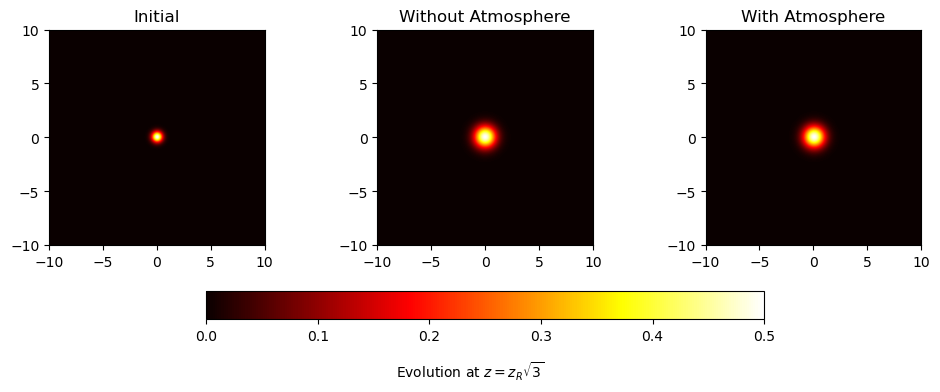

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

im0= axs[0].imshow(np.abs(exponential2D(spectral2d)), extent=[-10, 10, -10, 10], cmap='hot', origin='lower')
axs[0].set_title('Initial')
im2 = axs[1].imshow(np.abs(epsilon_evolution2), extent=[-10, 10, -10, 10], cmap='hot', origin='lower')
axs[1].set_title('Without Atmosphere')

im1 = axs[2].imshow(np.abs(ep_evo2_with_atm_small_n), extent=[-10, 10, -10, 10], cmap='hot', origin='lower')
axs[2].set_title('With Atmosphere')

fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.6, orientation='horizontal')
fig.text(0.5, 0.01,r'Evolution at $z=z_R\sqrt{3}$',  ha='center')

plt.savefig('req.pdf')
plt.show()

Text(0.5, 1.0, 'With Atmosphere')

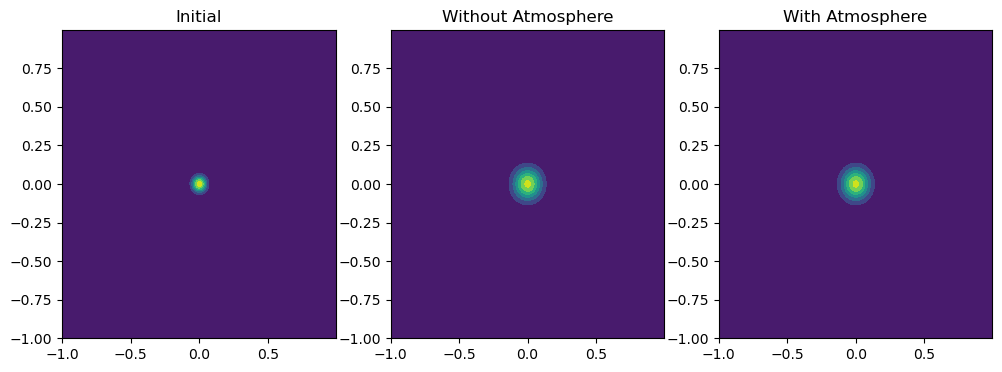

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

im0= axs[0].contourf(spectral2d.X, spectral2d.Y, np.abs(exponential2D(spectral2d)))
axs[0].set_title('Initial')
im2 = axs[1].contourf(spectral2d.X, spectral2d.Y,np.abs(epsilon_evolution2))
axs[1].set_title('Without Atmosphere')

im1 = axs[2].contourf(spectral2d.X, spectral2d.Y, np.abs(ep_evo2_with_atm_small_n))
axs[2].set_title('With Atmosphere')

#fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.6, orientation='horizontal')
#fig.text(0.5, 0.01,r'Evolution at $z=z_R\sqrt{3}$',  ha='center')
